In [1]:
# Parameters
run_id = "6138"
flow_name = "NBFlow"
task_id = "131220"

# Model Result Dashboard

We retrieve the model results so we can produce model diagnostics.

In [2]:
from metaflow import Step
import pandas as pd
import numpy as np
import altair as alt
from matplotlib import pyplot as plt

step = Step(f'{flow_name}/{run_id}/train')
model_results = step.task.data.model_results
y = model_results['test_labels']
X = model_results['test_inputs']
yhat = model_results['test_predictions']

print(f'Results for {run_id=} and {flow_name=}')

Results for run_id='6138' and flow_name='NBFlow'


## Training History

In [3]:
history = model_results['history']
df_history = pd.DataFrame(history)

In [4]:
train_df = df_history[['loss', 'accuracy']].copy()
train_df.loc[:,'partition'] = 'training'

val_df = df_history[['val_loss', 'val_accuracy']].rename(columns={'val_loss':'loss', 'val_accuracy':'accuracy'})
val_df.loc[:, 'partition'] = 'validation'

chart_data = pd.concat([train_df, val_df]).reset_index().rename(columns={'index':'epoch'})

loss = alt.Chart(chart_data).mark_line().encode(
    alt.X('epoch:O'),
    alt.Y('loss:Q'),
    color='partition:N',
    tooltip=['loss', 'partition']
).properties(
    width=400,
    title='Learning Curve: Binary Crossentropy Loss'
).interactive()

accuracy = alt.Chart(chart_data).mark_line().encode(
    alt.X('epoch:O'),
    alt.Y('accuracy:Q', scale=alt.Scale(domain=[.5, 1])),
    color='partition:N',
    tooltip=['accuracy', 'partition']
).properties(
    width=400,
    title='Learning Curve: Accuracy'
).interactive()

loss | accuracy

alt.HConcatChart(...)

In [5]:
df_history

,loss,accuracy,val_loss,val_accuracy
0,0.459876,0.78035,0.449739,0.8026
1,0.293774,0.88565,0.419774,0.8608
2,0.256791,0.90335,0.450834,0.8306


## Model Performance & Diagnostics

In [6]:
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                             roc_curve, RocCurveDisplay, 
                             precision_recall_curve, PrecisionRecallDisplay)
from sklearn import metrics
from sklearn.calibration import CalibrationDisplay

# confusion matrix
cm = confusion_matrix(y, yhat > 0.5)
cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neg', 'Pos'])

In [7]:
# roc curve
fpr, tpr, thresholds = roc_curve(y, yhat)
roc_auc = metrics.auc(fpr, tpr)
rocdisp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='1D CNN')

In [8]:
# precision recall curve
prec, recall, _ = precision_recall_curve(y, yhat)
prdisp = PrecisionRecallDisplay(precision=prec, recall=recall, estimator_name='1D CNN')


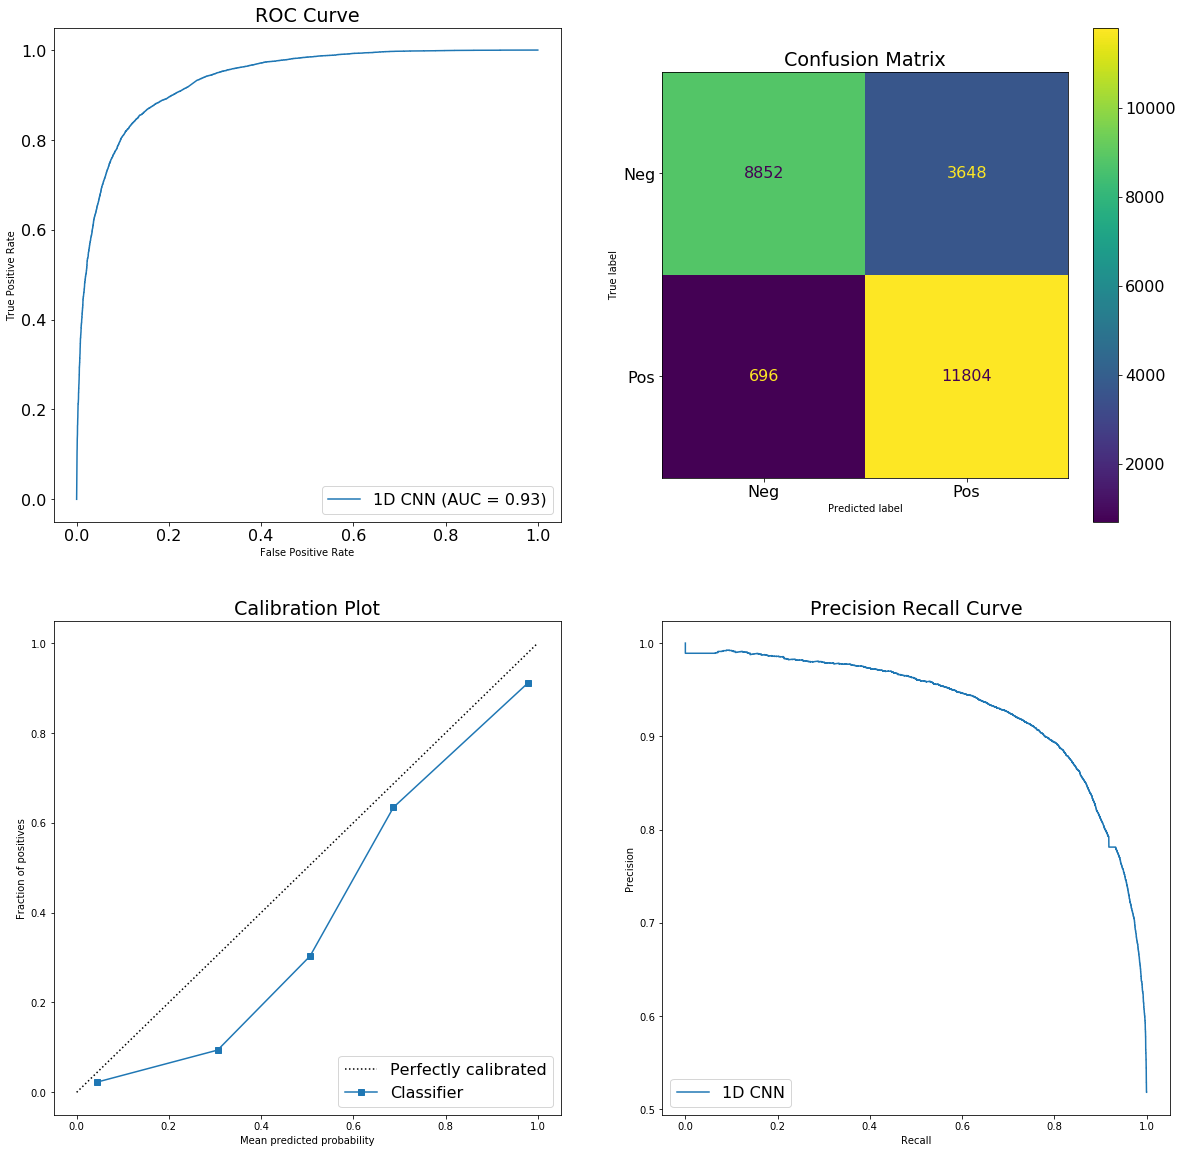

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,20))
plt.rcParams['font.size'] = '16'

CalibrationDisplay.from_predictions(y, yhat, ax=ax3)

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(16)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(16)
    
ax1.set_title("ROC Curve")
ax2.set_title("Confusion Matrix")
ax3.set_title("Calibration Plot")
ax4.set_title("Precision Recall Curve")
rocdisp.plot(ax=ax1)
cmdisp.plot(ax=ax2)
prdisp.plot(ax=ax4)
plt.show()